In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from pygsp import graphs
from additional_utils import create_SBM, AR_index, generate_concentric_circles
from sklearn.cluster import KMeans
import time
from mpl_toolkits.mplot3d import Axes3D
from sklearn import decomposition, datasets, manifold, discriminant_analysis

/home/nicolas/anaconda3/envs/pygsp_tutorial_graphsip/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


# Solution to connectedness phase transition in Erdös-Rényi graphs

In [2]:
N_val = [10, 50, 100, 250]
Pc = np.log(N_val) / N_val
P = np.zeros((6,len(N_val)))
P[0,:] = Pc * (1/2)
P[1,:] = Pc * (2/3)
P[2,:] = Pc * (4/5)
P[3,:] = Pc * (5/4)
P[4,:] = Pc * (3/2)
P[5,:] = Pc * (2)
N_trials = 200
is_conn = np.empty((N_trials, len(N_val), P.shape[0]))
is_conn[:] = np.nan

In [3]:
for n in np.arange(N_trials):
    for i in np.arange(len(N_val)):
        for j in np.arange(P.shape[0]):
            G = graphs.ErdosRenyi(N_val[i], p=P[j, i])
            is_conn[n,i,j] = G.is_connected()

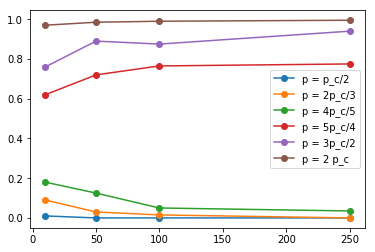

In [4]:
plt.plot(N_val, np.mean(is_conn,0), '-o')
plt.legend(['p = p_c/2', 'p = 2p_c/3', 'p = 4p_c/5', 'p = 5p_c/4', 'p = 3p_c/2', 'p = 2 p_c'])

# Solution to eigengap versus fuziness in balanced SBMs

In [2]:
N = 100; # number of nodes
k = 4; # number of blocks
c = 16; # average degree

z = np.tile(np.arange(k), (np.int(N/k),1))
truth = np.reshape(z.T, (N,1))[:,0]

epsi_c = (c - np.sqrt(c)) / (c + np.sqrt(c) * (k-1)); # critical fuzziness

N_trials = 200
DENOM = [40, 10, 4, 2, 1, 0.5, 0.25]
Gamma = np.zeros((len(DENOM), N_trials))
for d in np.arange(len(DENOM)):
    epsi = epsi_c / DENOM[d]; 
    pin = (k * c) / (N - k + (k - 1) * epsi * N)
    pout = (k * c * epsi) / (N - k + (k - 1) * epsi * N)
    for n in np.arange(N_trials):
        G = graphs.StochasticBlockModel(N=N, k=k, z=truth, p=pin, q=pout)
        eig_val, U = sp.sparse.linalg.eigsh(G.L, k=10, which='SM')
        Gamma[d,n] = (eig_val[k] - eig_val[k-1]) / eig_val[k]

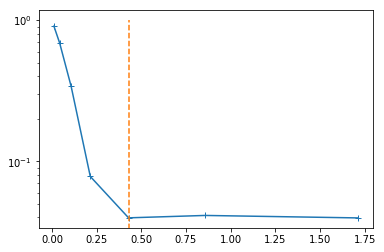

In [3]:
plt.semilogy(epsi_c / DENOM, np.mean(Gamma,1), '+-')
plt.plot([epsi_c, epsi_c], [0,1], '--')

# Solution to spectral clustering algorithm

#### The spectral clustering algorithm (with the combinatorial Laplacian)

In [6]:
def a_simple_spectral_clustering_algorithm(G, k): # inputs: the graph, and the number of wanted communities
    eig_val, U = sp.sparse.linalg.eigsh(G.L, k=k, which='SM')
    U_useful = U[:,1:]
    kmeans = KMeans(n_clusters=k, n_init=20).fit(U_useful)
    return kmeans.labels_ # output: community structure in vector com_structure

#### The SC algorithm on a simple example:

In [8]:
N = 500; # number of nodes
k = 4; # number of blocks
c = 16; # average degree

z = np.tile(np.arange(k), (np.int(N/k),1))
truth = np.reshape(z.T, (N,1))[:,0]

epsi_c = (c - np.sqrt(c)) / (c + np.sqrt(c) * (k-1)); # critical fuzziness
epsi = epsi_c / 40; # this is a very strong block structure

pin = (k * c) / (N - k + (k - 1) * epsi * N)
pout = (k * c * epsi) / (N - k + (k - 1) * epsi * N)

G = graphs.StochasticBlockModel(N=N, k=k, z=truth, p=pin, q=pout)

community_structure = a_simple_spectral_clustering_algorithm(G, k)
perf = AR_index(truth.astype('int'), community_structure)
print('The performance is ' + str(perf))

The performance is 1.0


# Solution to SC performance versus fuziness in balanced SBMs

In [9]:
N_trials = 100
DENOM = [40, 10, 4, 2, 1, 0.5, 0.25]
perf = np.zeros((len(DENOM), N_trials))

for d in np.arange(len(DENOM)):
    epsi = epsi_c / DENOM[d]; 
    for n in np.arange(N_trials):
        pin = (k * c) / (N - k + (k - 1) * epsi * N)
        pout = (k * c * epsi) / (N - k + (k - 1) * epsi * N)
        G = graphs.StochasticBlockModel(N=N, k=k, z=truth, p=pin, q=pout)
        community_structure = a_simple_spectral_clustering_algorithm(G, k)
        perf[d, n] = AR_index(truth.astype('int'), community_structure)

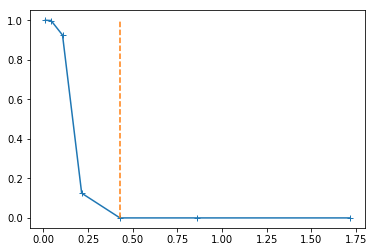

In [10]:
plt.figure()
plt.plot(epsi_c / DENOM, np.mean(perf,1), '+-')
plt.plot([epsi_c, epsi_c], [0,1], '--')

In order to approach the threshold even closer, it has been shown that SC on the so-called non-backtracking matrix (instead of on Laplacian matrices) performs close-to optimally in the sparse SBM case [Krzakala et al.](https://boulderschool.yale.edu/sites/default/files/files/PNAS-2013-Krzakala-20935-40.pdf))

# "Solution" to : Which similarity graph for the concentric data?

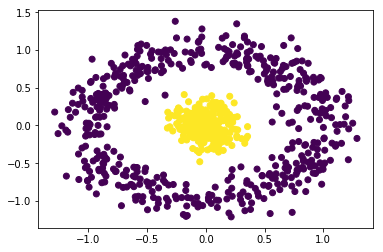

In [11]:
N_in=300 # number of nodes inside
N_out=500 # number of nodes outside
sigma_in= 0.15
sigma_out= 0.15
data, truth = generate_concentric_circles(N_in, N_out, sigma_in, sigma_out)
plt.figure()
plt.scatter(data[:,0], data[:,1], c=truth)

**1/ The kNN option.**

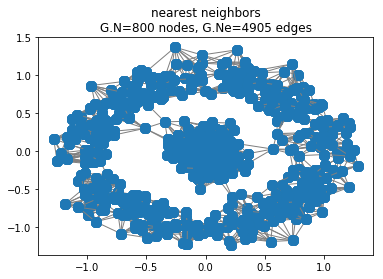

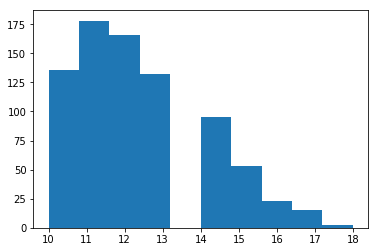

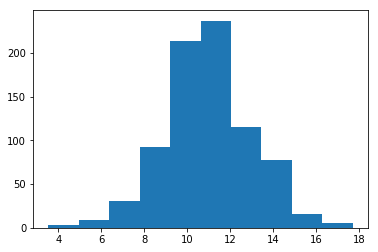

In [12]:
G = graphs.NNGraph(data, NNtype='knn', k=10, sigma=0.1, rescale=False, symmetrize_type='maximum')
G.truth = truth
G.plot()
plt.figure()
plt.hist(G.d,10);
plt.figure()
plt.hist(G.dw,10);

In [13]:
community_structure = a_simple_spectral_clustering_algorithm(G, 2)
perf = AR_index(G.truth.astype('int'), community_structure)
print('Performance is ' + str(perf))

Performance is 0.9949815089253653


Let's plot the performance versus $k$, the number of nearest neighbour to consider

In [14]:
K = [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 30, 40, 60, 80, 100, 150, 200, 250, 300]
N_trials = 10
N_in = 300 # number of nodes inside
N_out = 500 # number of nodes outside
sigma_in = 0.15 # variability inside circle
sigma_out = 0.15 # variability outside circle

sigma_w = 0.1 # the sigma of the Gaussian kernel to decide weights in the graph

time_to_compute = np.empty((len(K), N_trials)) * np.nan
SC_time = np.empty((len(K), N_trials)) * np.nan
perf = np.empty((len(K), N_trials)) * np.nan

for n in np.arange(N_trials):
    data, truth = generate_concentric_circles(N_in, N_out, sigma_in, sigma_out)
    for kk in np.arange(len(K)):
        k = K[kk]
        start_time = time.time()
        G = graphs.NNGraph(data, NNtype='knn', k=k, sigma=sigma_w, rescale=False, symmetrize_type='maximum')
        graph_creation_time = time.time() - start_time
        G.truth = truth
        community_structure = a_simple_spectral_clustering_algorithm(G, 2)
        time_to_compute[kk, n] = time.time() - start_time
        SC_time[kk,n] = time_to_compute[kk, n] - graph_creation_time
        perf[kk, n] = AR_index(G.truth.astype('int'), community_structure)

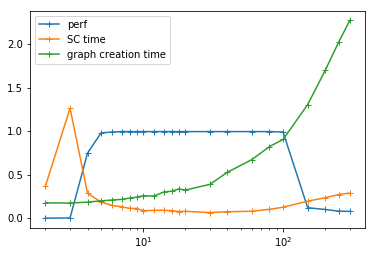

In [15]:
plt.semilogx(K, np.median(perf, 1), '+-')
plt.semilogx(K, np.median(SC_time,1), '+-')
plt.semilogx(K, np.median(time_to_compute-SC_time,1), '+-')
plt.legend(['perf', 'SC time', 'graph creation time'])

There exists an optimal value of $k$ for the nearest neighbor construction. One could also look at ```sigma_w``` in ```G = graphs.NNGraph(data, NNtype='knn', k=k, sigma=sigma_w, rescale=False, symmetrize_type='maximum')``` to see if it has an impact on performance

**2/ The $\epsilon$ option.**

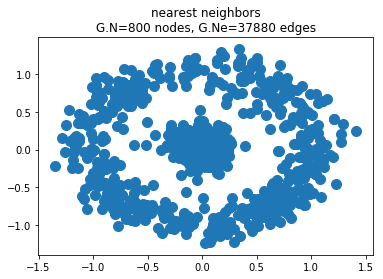

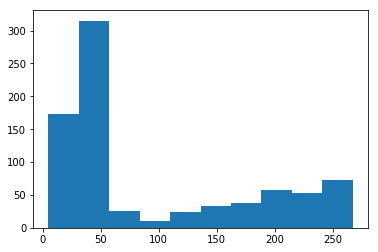

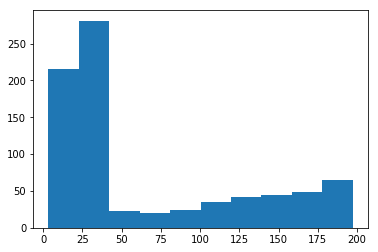

In [16]:
G = graphs.NNGraph(data, NNtype='radius', epsilon=0.3, sigma=sigma_w, rescale=False, symmetrize_type='maximum')
G.truth = truth
G.plot()
plt.figure()
plt.hist(G.d,10);
plt.figure()
plt.hist(G.dw,10);

In [17]:
community_structure = a_simple_spectral_clustering_algorithm(G, 2)
perf = AR_index(G.truth.astype('int'), community_structure)
print('Performance is ' + str(perf))

Performance is 0.9899748113207547


Let's plot the performance versus $\epsilon$, the radius to consider

In [18]:
EPSI = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
N_trials = 10
N_in = 300 # number of nodes inside
N_out = 500 # number of nodes outside
sigma_in = 0.15 # variability inside circle
sigma_out = 0.15 # variability outside circle

sigma_w = 0.1 # the sigma of the Gaussian kernel to decide weights in the graph

time_to_compute = np.empty((len(EPSI), N_trials)) * np.nan
SC_time = np.empty((len(EPSI), N_trials)) * np.nan
perf = np.empty((len(EPSI), N_trials)) * np.nan

for n in np.arange(N_trials):
    data, truth = generate_concentric_circles(N_in, N_out, sigma_in, sigma_out)
    for kk in np.arange(len(EPSI)):
        epsi = EPSI[kk]
        start_time = time.time()
        G = graphs.NNGraph(data, NNtype='radius', epsilon=epsi, sigma=sigma_w, rescale=False, symmetrize_type='maximum')
        graph_creation_time = time.time() - start_time
        G.truth = truth
        community_structure = a_simple_spectral_clustering_algorithm(G, 2)
        time_to_compute[kk, n] = time.time() - start_time
        SC_time[kk,n] = time_to_compute[kk, n] - graph_creation_time
        perf[kk, n] = AR_index(G.truth.astype('int'), community_structure)

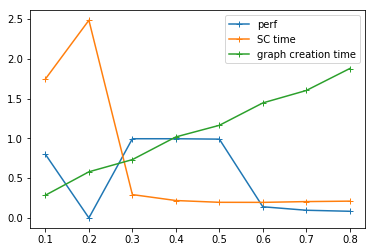

In [19]:
plt.plot(EPSI, np.median(perf, 1), '+-')
plt.plot(EPSI, np.median(SC_time,1), '+-')
plt.plot(EPSI, np.median(time_to_compute-SC_time,1), '+-')
plt.legend(['perf', 'SC time', 'graph creation time'])

In cases where the degrees are not very uniform, the SC algorithm based on the normalized Laplacian is a better option:

In [20]:
def a_second_simple_spectral_clustering_algorithm(G, k): # inputs: the graph, and the number of wanted communities
    G.compute_laplacian('normalized') # use normalized Laplacian 
    eig_val, U = sp.sparse.linalg.eigsh(G.L, k=k, which='SM')
    U_useful = U / np.tile(np.sqrt(np.sum(U**2,1)), (U.shape[1],1)).T # see von Luxburg's tutorial
    kmeans = KMeans(n_clusters=k, n_init=20).fit(U_useful)
    return kmeans.labels_ # output: community structure in vector com_structure

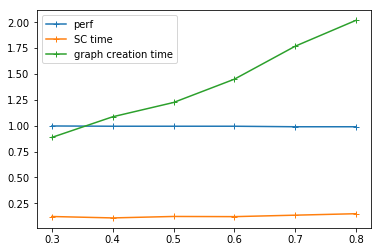

In [21]:
EPSI = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8] # the graph needs to be connected (epsi can't be too small)
N_trials = 10
N_in = 300 # number of nodes inside
N_out = 500 # number of nodes outside
sigma_in = 0.15 # variability inside circle
sigma_out = 0.15 # variability outside circle

sigma_w = 0.1 # the sigma of the Gaussian kernel to decide weights in the graph

time_to_compute = np.empty((len(EPSI), N_trials)) * np.nan
SC_time = np.empty((len(EPSI), N_trials)) * np.nan
perf = np.empty((len(EPSI), N_trials)) * np.nan

for n in np.arange(N_trials):
    data, truth = generate_concentric_circles(N_in, N_out, sigma_in, sigma_out)
    for kk in np.arange(len(EPSI)):
        epsi = EPSI[kk]
        start_time = time.time()
        G = graphs.NNGraph(data, NNtype='radius', epsilon=epsi, sigma=sigma_w, rescale=False, symmetrize_type='maximum')
        graph_creation_time = time.time() - start_time
        G.truth = truth
        community_structure = a_second_simple_spectral_clustering_algorithm(G, 2)
        time_to_compute[kk, n] = time.time() - start_time
        SC_time[kk,n] = time_to_compute[kk, n] - graph_creation_time
        perf[kk, n] = AR_index(G.truth.astype('int'), community_structure)
        
plt.plot(EPSI, np.median(perf, 1), '+-')
plt.plot(EPSI, np.median(SC_time,1), '+-')
plt.plot(EPSI, np.median(time_to_compute-SC_time,1), '+-')
plt.legend(['perf', 'SC time', 'graph creation time'])

# Solution to PCA vs Lap Eigenmaps on the Swiss Roll dataset

#### On the SwissRoll

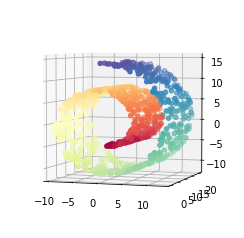

In [102]:
Axes3D

n_points = 1000
#X, color = datasets.make_s_curve(n_points, random_state=0)
X, color = datasets.make_swiss_roll(n_points, random_state=0)

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
ax.view_init(4, -72)

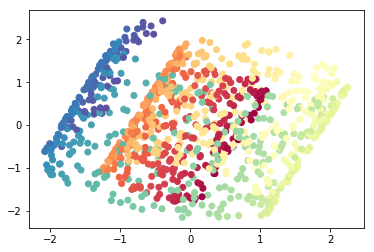

In [103]:
from sklearn.preprocessing import StandardScaler
X_sca = StandardScaler()
X = X_sca.fit_transform(X)

pca = decomposition.PCA(n_components=2)
emb_pca = pca.fit_transform(X)
plt.scatter(emb_pca[:, 0], emb_pca[:, 1], c=color, cmap=plt.cm.Spectral)

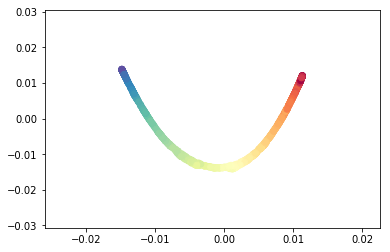

In [110]:
G = graphs.NNGraph(X, NNtype='knn', k=10, sigma=5, rescale=False, symmetrize_type='maximum')
G.compute_laplacian('normalized')
eig_val, U_n = sp.sparse.linalg.eigsh(G.L, k=3, which='SM')

d = np.power(G.dw, -0.5)
D = sp.sparse.diags(np.ravel(d), 0).tocsc()
U_rw = D * U_n
emb_le = U_rw[:, 1:]
plt.scatter(emb_le[:, 0], emb_le[:, 1], c=color, cmap=plt.cm.Spectral)

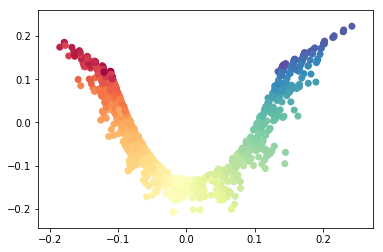

In [111]:
Lap_eigenmaps = manifold.SpectralEmbedding(n_components=2, affinity='precomputed', gamma=None, random_state=None, eigen_solver=None, n_neighbors=10, n_jobs=1)
emb_sk_le = Lap_eigenmaps.fit_transform(G.W.toarray())
plt.scatter(emb_sk_le[:,0], emb_sk_le[:,1], c=color, cmap=plt.cm.Spectral)

Our implementation is different from the one in sklearn. In sklearn they use the **left** eigenvectors of the random walk Laplacian and we use the **right** eigenvectors of the random walk Laplacian. This difference is under investigation..

**How about TSNE?**

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.002s...
[t-SNE] Computed neighbors for 1000 samples in 0.046s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.503393
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.268749
[t-SNE] Error after 300 iterations: 0.593065


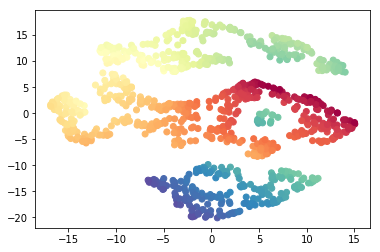

In [53]:
tsne = manifold.TSNE(n_components=2, verbose=1, perplexity=50, n_iter=300)
emb_tsne = tsne.fit_transform(X)
plt.scatter(emb_tsne[:,0], emb_tsne[:,1], c=color, cmap=plt.cm.Spectral)

#### On the 3D concentric data

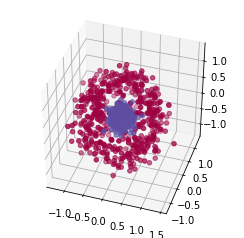

In [90]:
N_in=300 # number of nodes inside
N_out=500 # number of nodes outside
sigma_in= 0.15
sigma_out= 0.15
X, truth = generate_concentric_circles(N_in, N_out, sigma_in, sigma_out, d=3)

Axes3D

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], c=truth, cmap=plt.cm.Spectral)
ax.view_init(40, -72)

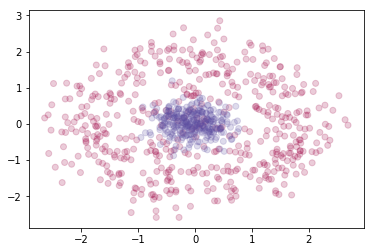

In [91]:
from sklearn.preprocessing import StandardScaler
X_sca = StandardScaler()
X = X_sca.fit_transform(X)

pca = decomposition.PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=truth, cmap=plt.cm.Spectral, alpha=0.2)

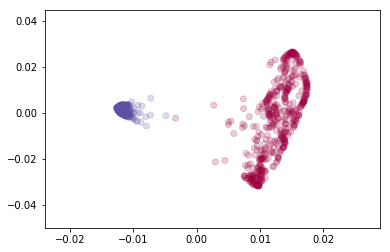

In [92]:
G = graphs.NNGraph(X, NNtype='knn', k=10, sigma=0.5, rescale=False, symmetrize_type='maximum')
G.compute_laplacian('normalized')
eig_val, U_n = sp.sparse.linalg.eigsh(G.L, k=3, which='SM')
d = np.power(G.dw, -0.5)
D = sp.sparse.diags(np.ravel(d), 0).tocsc()
U_rw = D * U_n
X_le = U_rw[:, 1:]
plt.scatter(X_le[:, 0], X_le[:, 1], c=truth, cmap=plt.cm.Spectral, alpha=0.2)

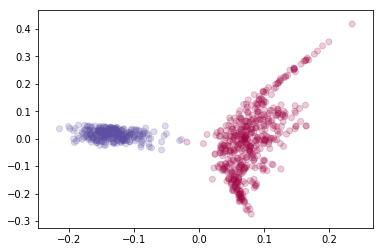

In [93]:
Lap_eigenmaps = manifold.SpectralEmbedding(n_components=2, affinity='precomputed', gamma=None, random_state=None, eigen_solver=None, n_neighbors=10, n_jobs=1)
emb_sk_le = Lap_eigenmaps.fit_transform(G.W.toarray())
plt.scatter(emb_sk_le[:,0], emb_sk_le[:,1], c=truth, cmap=plt.cm.Spectral, alpha=0.2)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 800 samples in 0.001s...
[t-SNE] Computed neighbors for 800 samples in 0.040s...
[t-SNE] Computed conditional probabilities for sample 800 / 800
[t-SNE] Mean sigma: 0.360651
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.530766
[t-SNE] Error after 300 iterations: 0.673545


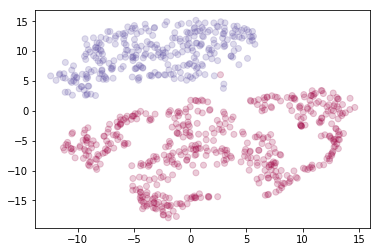

In [95]:
tsne = manifold.TSNE(n_components=2, verbose=1, perplexity=50, n_iter=300)
emb_tsne = tsne.fit_transform(X)
plt.scatter(emb_tsne[:,0], emb_tsne[:,1], c=truth, cmap=plt.cm.Spectral, alpha=0.2)

## Exercise: Laplacian eigenmaps on hand digits

In [112]:
digits = datasets.load_digits(n_class=6)
X = digits.data
y = digits.target
n_samples, n_features = X.shape
n_neighbors = 30

print(f"{n_samples} digits, {n_features} features")

1083 digits, 64 features


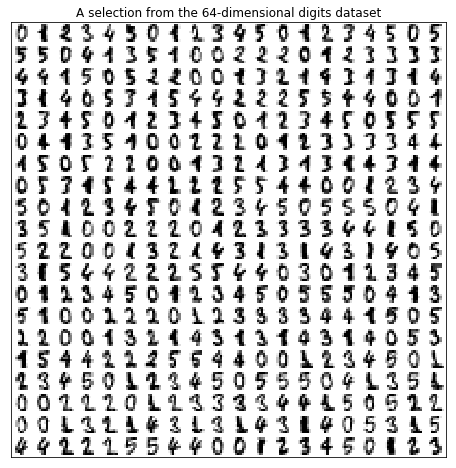

In [113]:
# Plot images of the digits
n_img_per_row = 20
img = np.zeros((10 * n_img_per_row, 10 * n_img_per_row))
for i in range(n_img_per_row):
    ix = 10 * i + 1
    for j in range(n_img_per_row):
        iy = 10 * j + 1
        img[ix:ix + 8, iy:iy + 8] = X[i * n_img_per_row + j].reshape((8, 8))

plt.figure(figsize=(8,8))
plt.imshow(img, cmap=plt.cm.binary)
plt.xticks([])
plt.yticks([])
plt.title('A selection from the 64-dimensional digits dataset');

In [114]:
t0 = time.time()
X_pca = decomposition.TruncatedSVD(n_components=2).fit_transform(X)
t_pca = time.time() - t0

se = manifold.SpectralEmbedding(n_components=2, random_state=0, n_neighbors=100, eigen_solver="arpack", affinity='rbf')
t0 = time.time()
X_se = se.fit_transform(X)
t_se = time.time() - t0

t0 = time.time()
#W = (se.affinity_matrix_).toarray()
W = se.affinity_matrix_
W = W - np.diag(np.diag(W))
G = graphs.Graph(W)
G.compute_laplacian('normalized')
eig_val, U_n = sp.sparse.linalg.eigsh(G.L, k=3, which='SM')
d = np.power(G.dw, -0.5)
D = sp.sparse.diags(np.ravel(d), 0).tocsc()
U_rw = D * U_n
X_se2 = U_rw[:, 1:]
t_se2 = time.time() - t0

tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
t0 = time.time()
X_tsne = tsne.fit_transform(X)
t_tsne = time.time() - t0

ArpackNoConvergence: ARPACK error -1: No convergence (10831 iterations, 0/3 eigenvectors converged)

In [ ]:
# Scale and visualize the embedding vectors
def plot_embedding(X, title=None, ax=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    if ax is None:
        plt.figure()
        ax = plt.subplot(111)
    for i in range(X.shape[0]):
        ax.text(X[i, 0], X[i, 1], str(digits.target[i]),
                color=plt.cm.Set1(y[i] / 10.),
                fontdict={'weight': 'bold', 'size': 9})

    shown_images = np.array([[1., 1.]])  # just something big
    for i in range(digits.data.shape[0]):
        dist = np.sum((X[i] - shown_images) ** 2, 1)
        if np.min(dist) < 4e-3:
            # don't show points that are too close
            continue
        shown_images = np.r_[shown_images, [X[i]]]
        imagebox = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
            X[i])
        ax.add_artist(imagebox)

    ax.set_xticks([]), ax.set_yticks([])
    if title is not None:
        ax.set_title(title)

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(20, 20))

title = f"Principal Component projection of the digits (time {t_pca:.2f}s)"
plot_embedding(X_pca, title, axes[0, 0])

title = f"t-SNE embedding of the digits (time {t_tsne:.2f}s)"
plot_embedding(X_tsne, title, axes[0, 1])

title = f"Spectral embedding of the digits (time {t_se:.2f}s)"
plot_embedding(X_se, title, axes[1, 0])

title = f"Spectral embedding 2 of the digits (time {t_se2:.2f}s)"
plot_embedding(X_se2, title, axes[1, 1])

Note that this spectral embedding is for k_nearest_neighbour = 100. It varies very much vs k!

In [88]:
G.is_connected()

True

# Brouillon

In [ ]:
N = 100; # number of nodes
k = 4; # number of blocks
c = 16; # average degree

com_size = np.ones(k) * (N/k)
com_size = com_size.astype(int)

epsi_c = (c - np.sqrt(c)) / (c + np.sqrt(c) * (k-1)); # critical fuzziness

N_trials = 200
DENOM = [40, 10, 4, 2, 1, 0.5, 0.25]
Gamma = np.zeros((len(DENOM), N_trials))
for d in np.arange(len(DENOM)):
    epsi = epsi_c / DENOM[d]; 
    for n in np.arange(N_trials):
        A, truth = create_SBM(N, k, c, epsi, com_size)
        G = graphs.Graph(A)
        eig_val, U = sp.sparse.linalg.eigsh(G.L, k=10, which='SM')
        Gamma[d,n] = (eig_val[k] - eig_val[k-1]) / eig_val[k]

In [ ]:
plt.semilogy(epsi_c / DENOM, np.mean(Gamma,1), '+-')
plt.plot([epsi_c, epsi_c], [0,1], '--')

In [ ]:
N = 500; # number of nodes
k = 4; # number of blocks
c = 16; # average degree

com_size = np.ones(k) * (N/k)
com_size = com_size.astype(int)

epsi_c = (c - np.sqrt(c)) / (c + np.sqrt(c) * (k-1)); # critical fuzziness
epsi = epsi_c / 40; # this is a very strong block structure

A, truth = create_SBM(N, k, c, epsi, com_size)
G = graphs.Graph(A)
G.truth = truth

community_structure = a_simple_spectral_clustering_algorithm(G, k)
perf = AR_index(G.truth.astype('int'), community_structure)
print('The performance is ' + str(perf))

In [ ]:
N_trials = 200
DENOM = [40, 10, 4, 2, 1, 0.5, 0.25]
perf = np.zeros((len(DENOM), N_trials))

for d in np.arange(len(DENOM)):
    epsi = epsi_c / DENOM[d]; 
    for n in np.arange(N_trials):
        A, truth = create_SBM(N, k, c, epsi, com_size)
        G = graphs.Graph(A)
        G.truth = truth
        community_structure = a_simple_spectral_clustering_algorithm(G, k)
        perf[d, n] = AR_index(G.truth.astype('int'), community_structure)

In [ ]:
G = graphs.NNGraph(X, NNtype='knn', k=10, sigma=5, rescale=False, symmetrize_type='maximum')
G.compute_laplacian('normalized')
eig_val, U_n = sp.sparse.linalg.eigsh(G.L, k=3, which='SM')
#d = np.power(G.dw, -0.5)
#D = sp.sparse.diags(np.ravel(d), 0).tocsc()
#U_rw = D * U_n
#emb_le = U_rw[:, 1:]
#plt.scatter(emb_le[:, 0], emb_le[:, 1], c=color, cmap=plt.cm.Spectral)

d = np.power(G.dw, 0.5)
D = sp.sparse.diags(np.ravel(d), 0).tocsc()
U_rw = D * U_n
emb_le = U_rw[:, 1:]
plt.scatter(emb_le[:, 0], emb_le[:, 1], c=color, cmap=plt.cm.Spectral)